Objective: Make a selection of nine paintings for the exhibition catalogue to be selected from Wikidata and rendered multi-format in Quarto.

The below Python code uses SPARQLWrapper to retrieve data from Wikidata based on a SPARQL query.

Wikidata link: [http://www.wikidata.org/entity/Q18689231](http://www.wikidata.org/entity/Q18689231)

Title: Maria Theresa, Archduchess of Habsburg

Year: 1730

Creator: Rosalba Carriera

Copyright: public domain



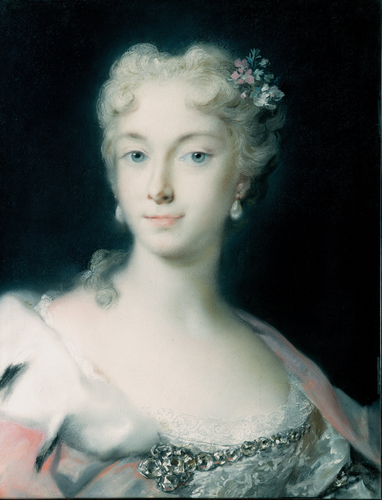




Wikidata link: [http://www.wikidata.org/entity/Q18689261](http://www.wikidata.org/entity/Q18689261)

Title: A Gentleman in a Gold Patterned Coat and Violet-Brown Cape

Year: 1727

Creator: Rosalba Carriera

Copyright: public domain



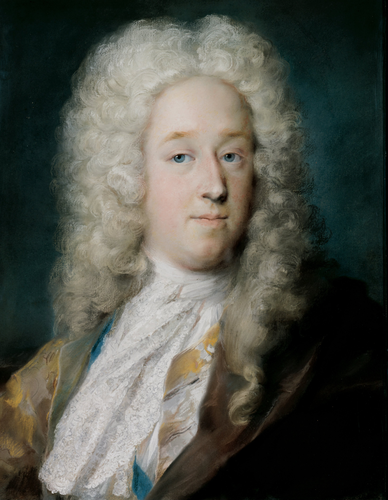




Wikidata link: [http://www.wikidata.org/entity/Q18689275](http://www.wikidata.org/entity/Q18689275)

Title: Louis XV of France as Dauphin

Year: 1720

Creator: Rosalba Carriera

Copyright: public domain



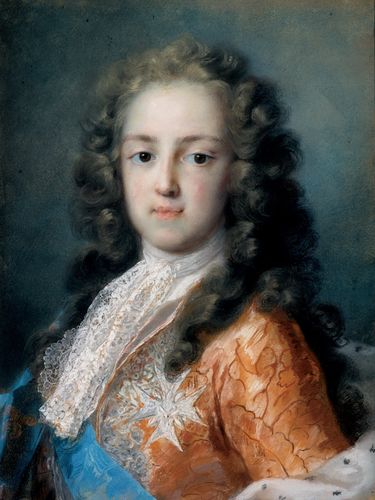




Wikidata link: [http://www.wikidata.org/entity/Q19266867](http://www.wikidata.org/entity/Q19266867)

Title: Las tres velas

Year: 1903

Creator: Joaquín Sorolla

Copyright: public domain



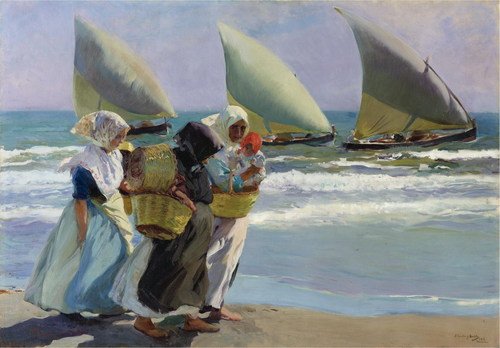




Wikidata link: [http://www.wikidata.org/entity/Q28798167](http://www.wikidata.org/entity/Q28798167)

Title: The Singer Faustina Bordoni (1697-1781) with a Musical Score

Year: 1724

Creator: Rosalba Carriera

Copyright: public domain



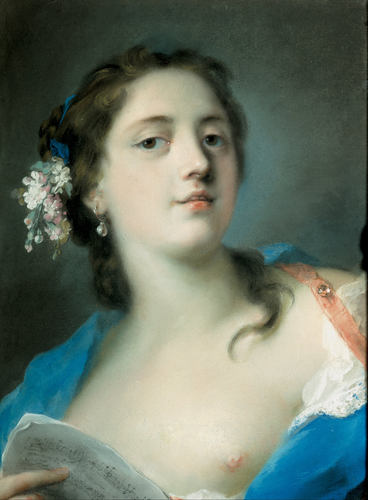




Wikidata link: [http://www.wikidata.org/entity/Q50326304](http://www.wikidata.org/entity/Q50326304)

Title: Judgement of Paris

Year: 1712

Creator: Adriaen van der Werff

Copyright: public domain



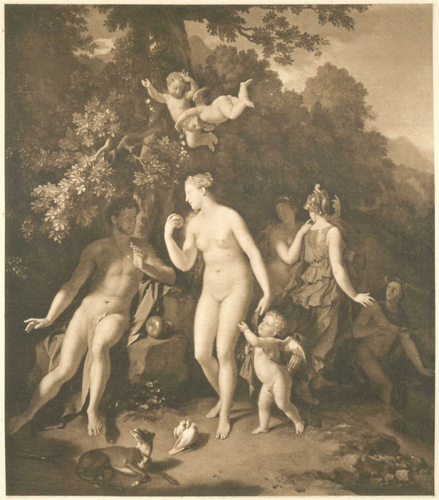




Wikidata link: [http://www.wikidata.org/entity/Q50326304](http://www.wikidata.org/entity/Q50326304)

Title: Judgement of Paris

Year: 1712

Creator: Adriaen van der Werff

Copyright: public domain



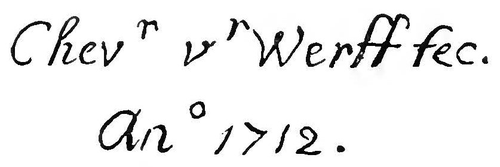




Wikidata link: [http://www.wikidata.org/entity/Q50327445](http://www.wikidata.org/entity/Q50327445)

Title: Youthful self-portrait

Year: 1765

Creator: Anton Graff

Copyright: public domain



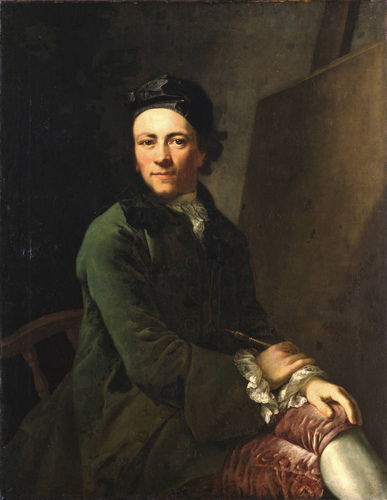




Wikidata link: [http://www.wikidata.org/entity/Q64541395](http://www.wikidata.org/entity/Q64541395)

Title: Portrait of Heinrich von Brühl

Year: 1753

Creator: Marcello Bacciarelli

Copyright: public domain



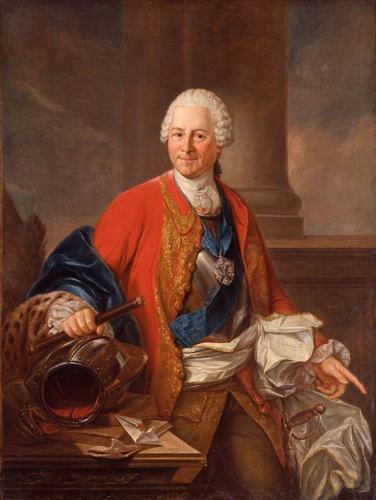

In [4]:
from SPARQLWrapper import SPARQLWrapper, JSON
from PIL import Image
import requests

# VARIABLES

sparql_endpoint_url = 'https://query.wikidata.org/bigdata/namespace/wdq/sparql'
wikibase_url = 'https://www.wikidata.org'
api_url = '/w/api.php'

# Wikidata requires a user agent header to prevent spam requests
user_agent = 'Ex_Books_conference_bot/0.0 (https://github.com/SimonXIX/Experimental_Books_workshop; ad7588@coventry.ac.uk)'

# SPARQL query
# see in Wikidata's Query Service GUI at:
# https://query.wikidata.org/#SELECT%20%3Fitem%20WHERE%20%7B%0A%20%20SERVICE%20wikibase%3Alabel%20%7B%20bd%3AserviceParam%20wikibase%3Alanguage%20"%5BAUTO_LANGUAGE%5D%2Cen".%20%7D%0A%20%20%0A%20%20%3Fitem%20wdt%3AP31%20wd%3AQ3305213.%0A%7D%0ALIMIT%2010
query = """
#defaultView:ImageGrid
# limit to nine results
SELECT ?item ?itemLabel ?inceptionyear ?creator ?creatorLabel ?copyright ?copyrightLabel ?image WHERE {
  ?item wdt:P31 wd:Q3305213;
    wdt:P195 wd:Q4890;
    wdt:P170 ?creator;
    wdt:P18 ?image;
    wdt:P6216 ?copyright.
  {
    ?item wdt:P571 ?inception.
    BIND(YEAR(?inception) AS ?inceptionyear)
  }
  FILTER((1700  <= ?inceptionyear) && (?inceptionyear < 2000 ))
  SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
}
LIMIT 9
"""

# SUBROUTINES

def get_delay(date):
    try:
        date = datetime.datetime.strptime(date, '%a, %d %b %Y %H:%M:%S GMT')
        timeout = int((date - datetime.datetime.now()).total_seconds())
    except ValueError:
        timeout = int(date)
    return timeout

def get_image(url, headers):
    r = requests.get(url, headers=headers, stream=True)
    if r.status_code == 200:
        im = Image.open(r.raw)
        return im
    if r.status_code == 500:
        return None
    if r.status_code == 403:
        return None
    if r.status_code == 429:
        timeout = get_delay(r.headers['retry-after'])
        print('Timeout {} m {} s'.format(timeout // 60, timeout % 60))
        time.sleep(timeout)
        get_image(url, headers)

# MAIN PROGRAM

# create SPARQL query
sparql = SPARQLWrapper(sparql_endpoint_url, agent=user_agent)

# retrieve results and convert to JSON format
sparql.setQuery(query)
sparql.setReturnFormat(JSON)
result = sparql.query().convert()

# for each result, print various data fields
for item in result['results']['bindings']:
    print('Wikidata link: ' + '[' + item['item']['value'] + ']' + '(' + item['item']['value'] + ')' + '\n')
    print('Title: ' + item['itemLabel']['value'] + '\n')
    print('Year: ' + item['inceptionyear']['value'] + '\n')
    print('Creator: ' + item['creatorLabel']['value'] + '\n')
    print('Copyright: ' + item['copyrightLabel']['value'] + '\n')

    # get image from image URL and display resized version
    image_url=item['image']['value']
    headers = {'User-Agent': 'Ex_Books_conference_bot/0.0 (https://github.com/SimonXIX/Experimental_Books_workshop; ad7588@coventry.ac.uk)'}
    im = get_image(image_url, headers)
    im.thumbnail((500, 500), Image.Resampling.LANCZOS)
    display(im)
    print('\n\n')